In [94]:
import os

import datetime
from functools import reduce
from matplotlib import ticker
from dateutil.relativedelta import relativedelta
import numpy as np
import pandas as pd
import seaborn
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

# plot setting
LABEL_SIZE = 20
matplotlib.rcParams['figure.figsize'] = 15., 6.
matplotlib.rcParams['xtick.labelsize'] = LABEL_SIZE 
matplotlib.rcParams['ytick.labelsize'] = LABEL_SIZE
matplotlib.rcParams['axes.labelsize'] = LABEL_SIZE + 5
matplotlib.rcParams['axes.grid'] = True
matplotlib.rcParams['axes.titlesize'] = LABEL_SIZE + 5
matplotlib.rcParams['grid.color'] = 'lightgrey'
matplotlib.rcParams['grid.linewidth'] = 0.5
matplotlib.rcParams['legend.loc'] = 'lower left'
matplotlib.rcParams['legend.fontsize'] = LABEL_SIZE - 5
matplotlib.rcParams['legend.markerscale'] = 3.0

seaborn.set(style='darkgrid', rc={
    'grid.color': 'lightgrey',
    'grid.linewidth': 0.5
})
seaborn.set_context('notebook', font_scale=2.0)
# sns.set_context("paper", rc={"font.size":8,"axes.titlesize":8,"axes.labelsize":5})

pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.options.mode.chained_assignment = None

In [95]:
df = pd.read_csv(
    'test.csv', parse_dates=['datetime'], 
    dtype={'pid': str, 'location': str, 'activity': np.int32},
    # usecols=['datetime', 'pid', 'location']
)

df = df.sort_values(['pid', 'datetime'])

loc = sorted(df['location'].unique())
enum_loc = dict(zip(loc, range(1, len(loc) + 1)))
pids = df['pid'].unique().tolist()

df['enum_loc'] = df['location'].apply(lambda x: enum_loc[x])
df['year'] = df['datetime'].apply(lambda x: x.year)
df['month'] = df['datetime'].apply(lambda x: x.month)
df['week'] = df['datetime'].apply(lambda x: int(int(x.timestamp()) / float(3600 * 24 * 7)))
df['day'] = df['datetime'].apply(lambda x: x.day)
df['hour'] = df['datetime'].apply(lambda x: x.hour)
df['weekday'] = df['datetime'].apply(lambda x: x.isoweekday())
df['timepoint'] = df['datetime'].apply(
    lambda x: int((
        x - datetime.datetime(x.year, x.month, 1, 0, 0)
    ).total_seconds())
)

years = df['year'].unique().tolist()

print('location: ', enum_loc)
print('PID: ', pids)

location:  {'Back Door': 1, 'Bathroom': 2, 'Bed': 3, 'Bedroom': 4, 'Fridge Door': 5, 'Front Door': 6, 'Hallway': 7, 'Kettle': 8, 'Kitchen': 9, 'Lounge': 10, 'Oven': 11}
PID:  ['LDWHYJWZNPCC', 'PYIBDUWZNQDR', 'RXGAEDNVQPAW', 'TWAPHZBFVVFS', 'YKRXVPEVALUO']


In [ ]:
df = pd.concat([df, df['datetime'].apply(lambda x: pd.Series({'month': x.month, 'weekday': x.isoweekday(), 'hour': x.hour}))], axis=1)

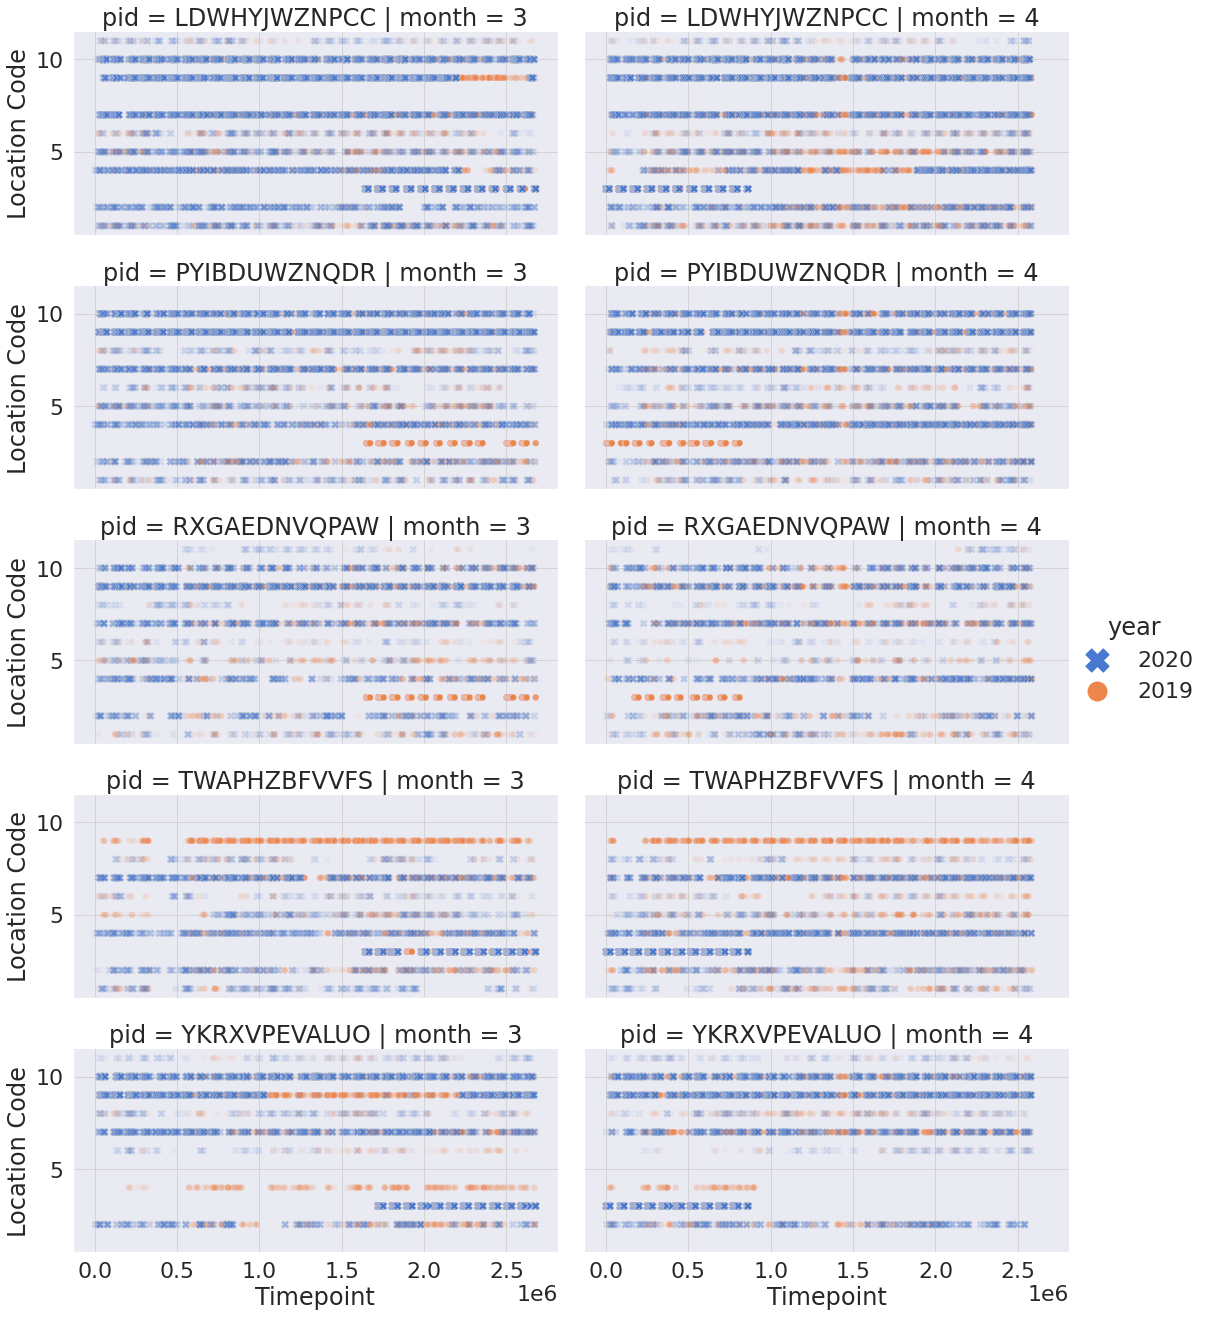

In [20]:
g = seaborn.relplot(
    x='timepoint', y='enum_loc', hue='year', size='year', style='year',
    sizes=(40, 60), size_order=[2020, 2019], hue_order=[2020, 2019],
    palette='muted', alpha=0.05, height=3.75, aspect=2,
    row='pid', col='month', col_order=[3, 4],
    data=df
)
g.set_axis_labels("Timepoint", "Location Code")  # .tight_layout(w_pad=2)
# g.set_xticklabels(fontsize=10)  # (rotation=[deg], )
# g.set(yticks=enum_loc.keys())

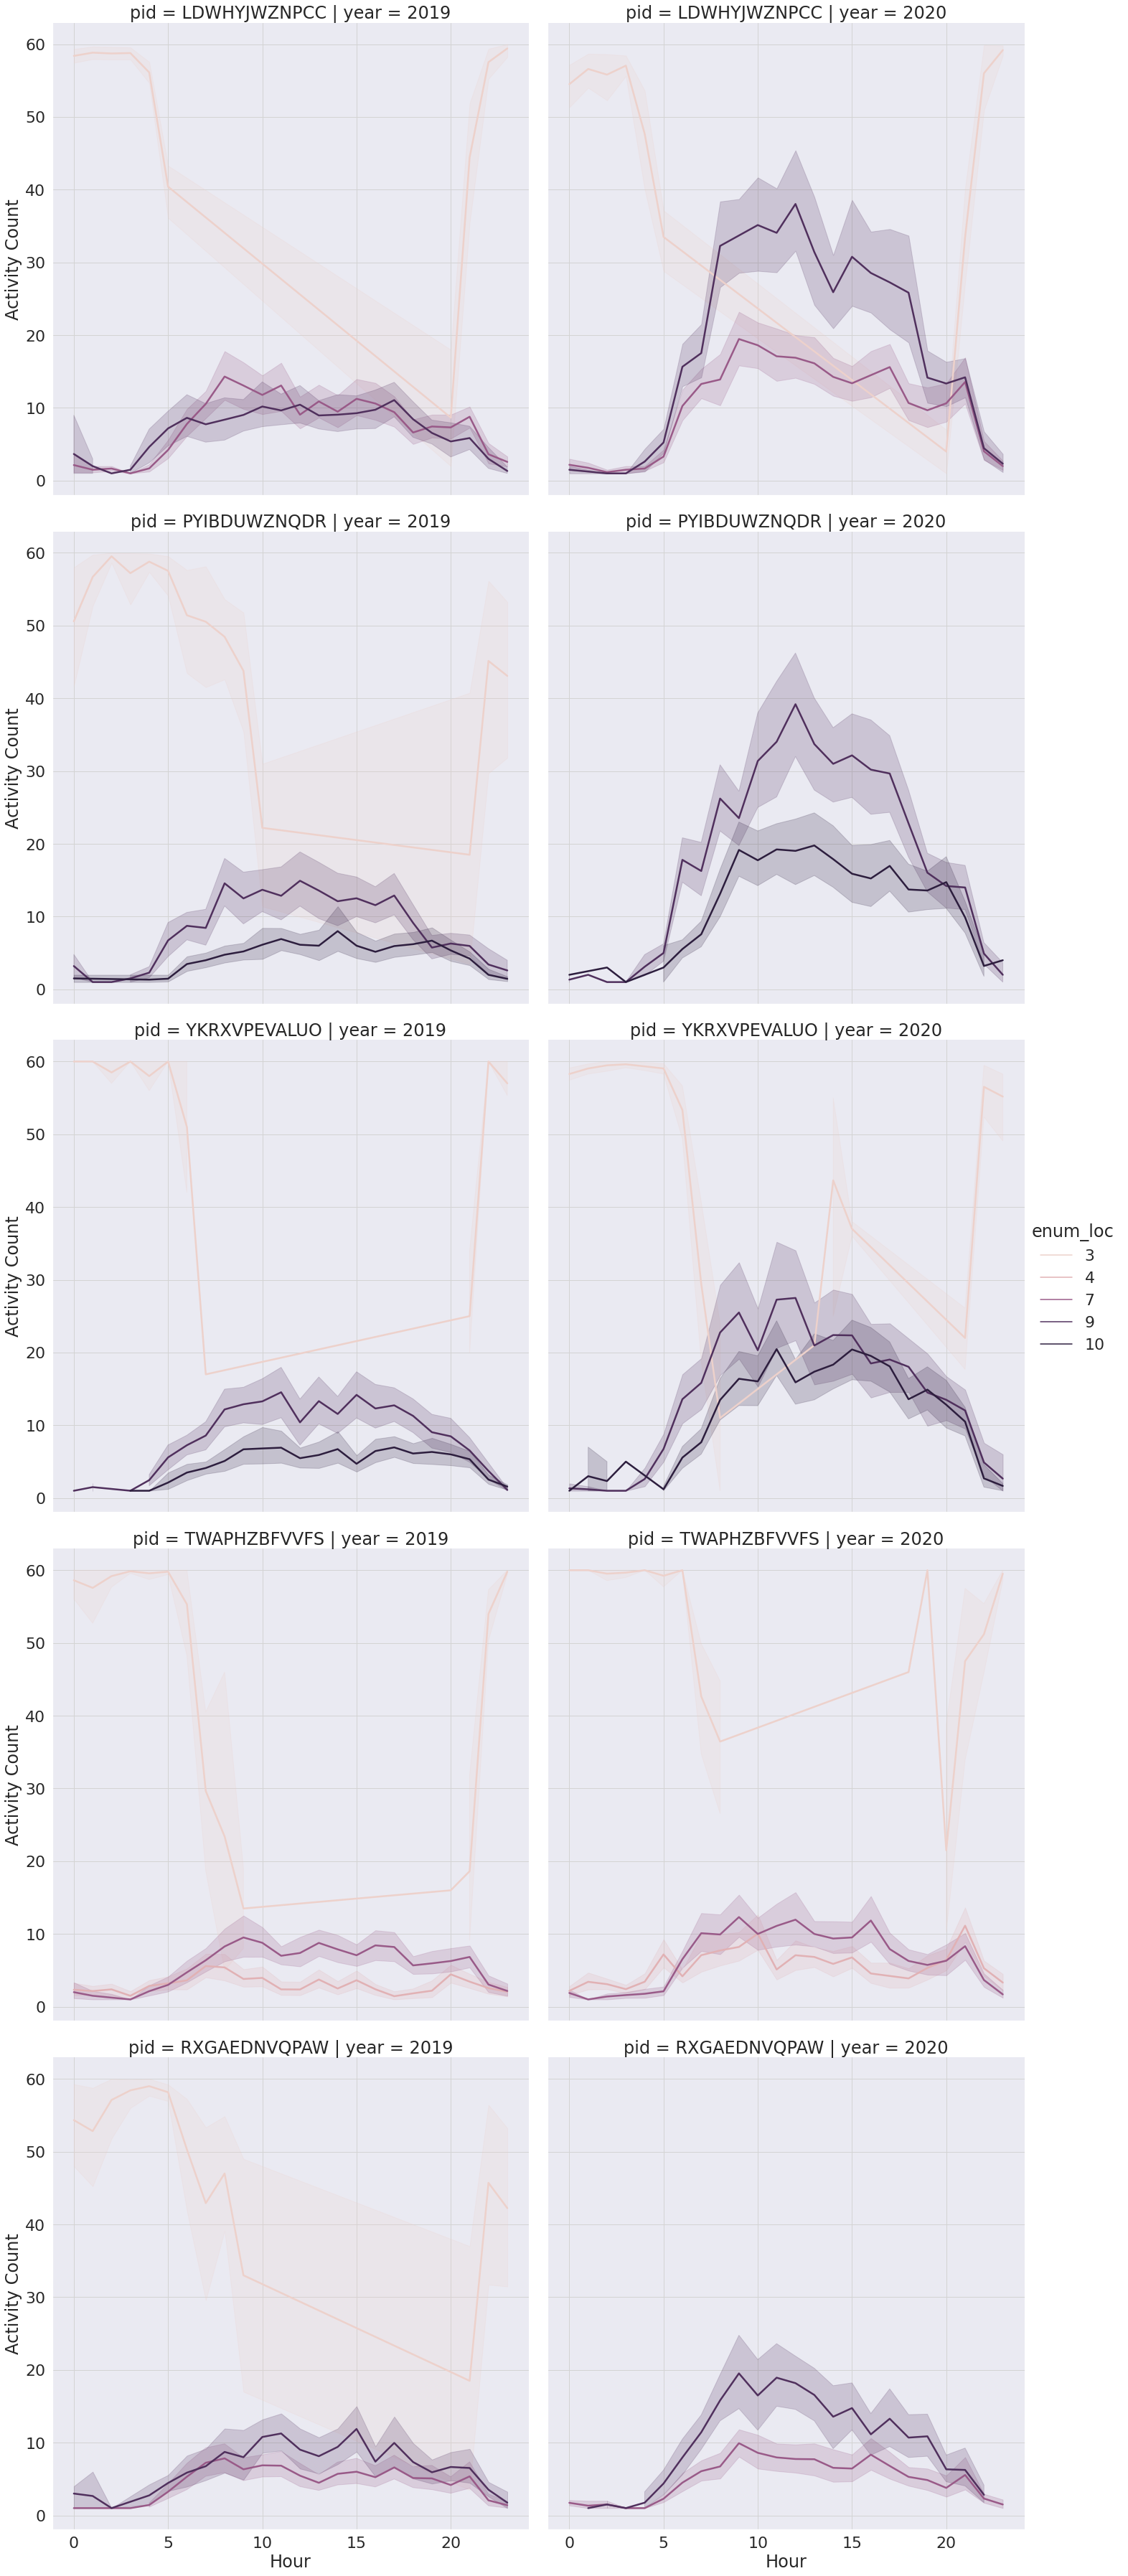

In [96]:
NLARGEST = 3  # max 11

df_daily = df[['pid', 'year', 'day','hour', 'activity', 'location']]

df_daily = df_daily.groupby(
    ['pid', 'year', 'day', 'hour', 'location']
).sum().reset_index().sort_values('hour')

df_temp = df_daily.groupby(['pid', 'enum_loc'])['activity'].sum()
df_temp = df_temp.groupby(level='pid').nlargest(NLARGEST).reset_index(level=0, drop=True).reset_index()[['pid', 'enum_loc']]

keys = list(df_temp.columns.values)
i1 = df_daily.set_index(keys).index
i2 = df_temp.set_index(keys).index
df_daily = df_daily[i1.isin(i2)]

g = seaborn.relplot(
    x='hour', y='activity', kind='line', linewidth=2.5, col='year', row='pid', # ci='sd',
    hue='location', data=df_daily, height=10, aspect=1,
)
# g.fig.autofmt_xdate()
g.set_axis_labels("Hour", "Activity Count")

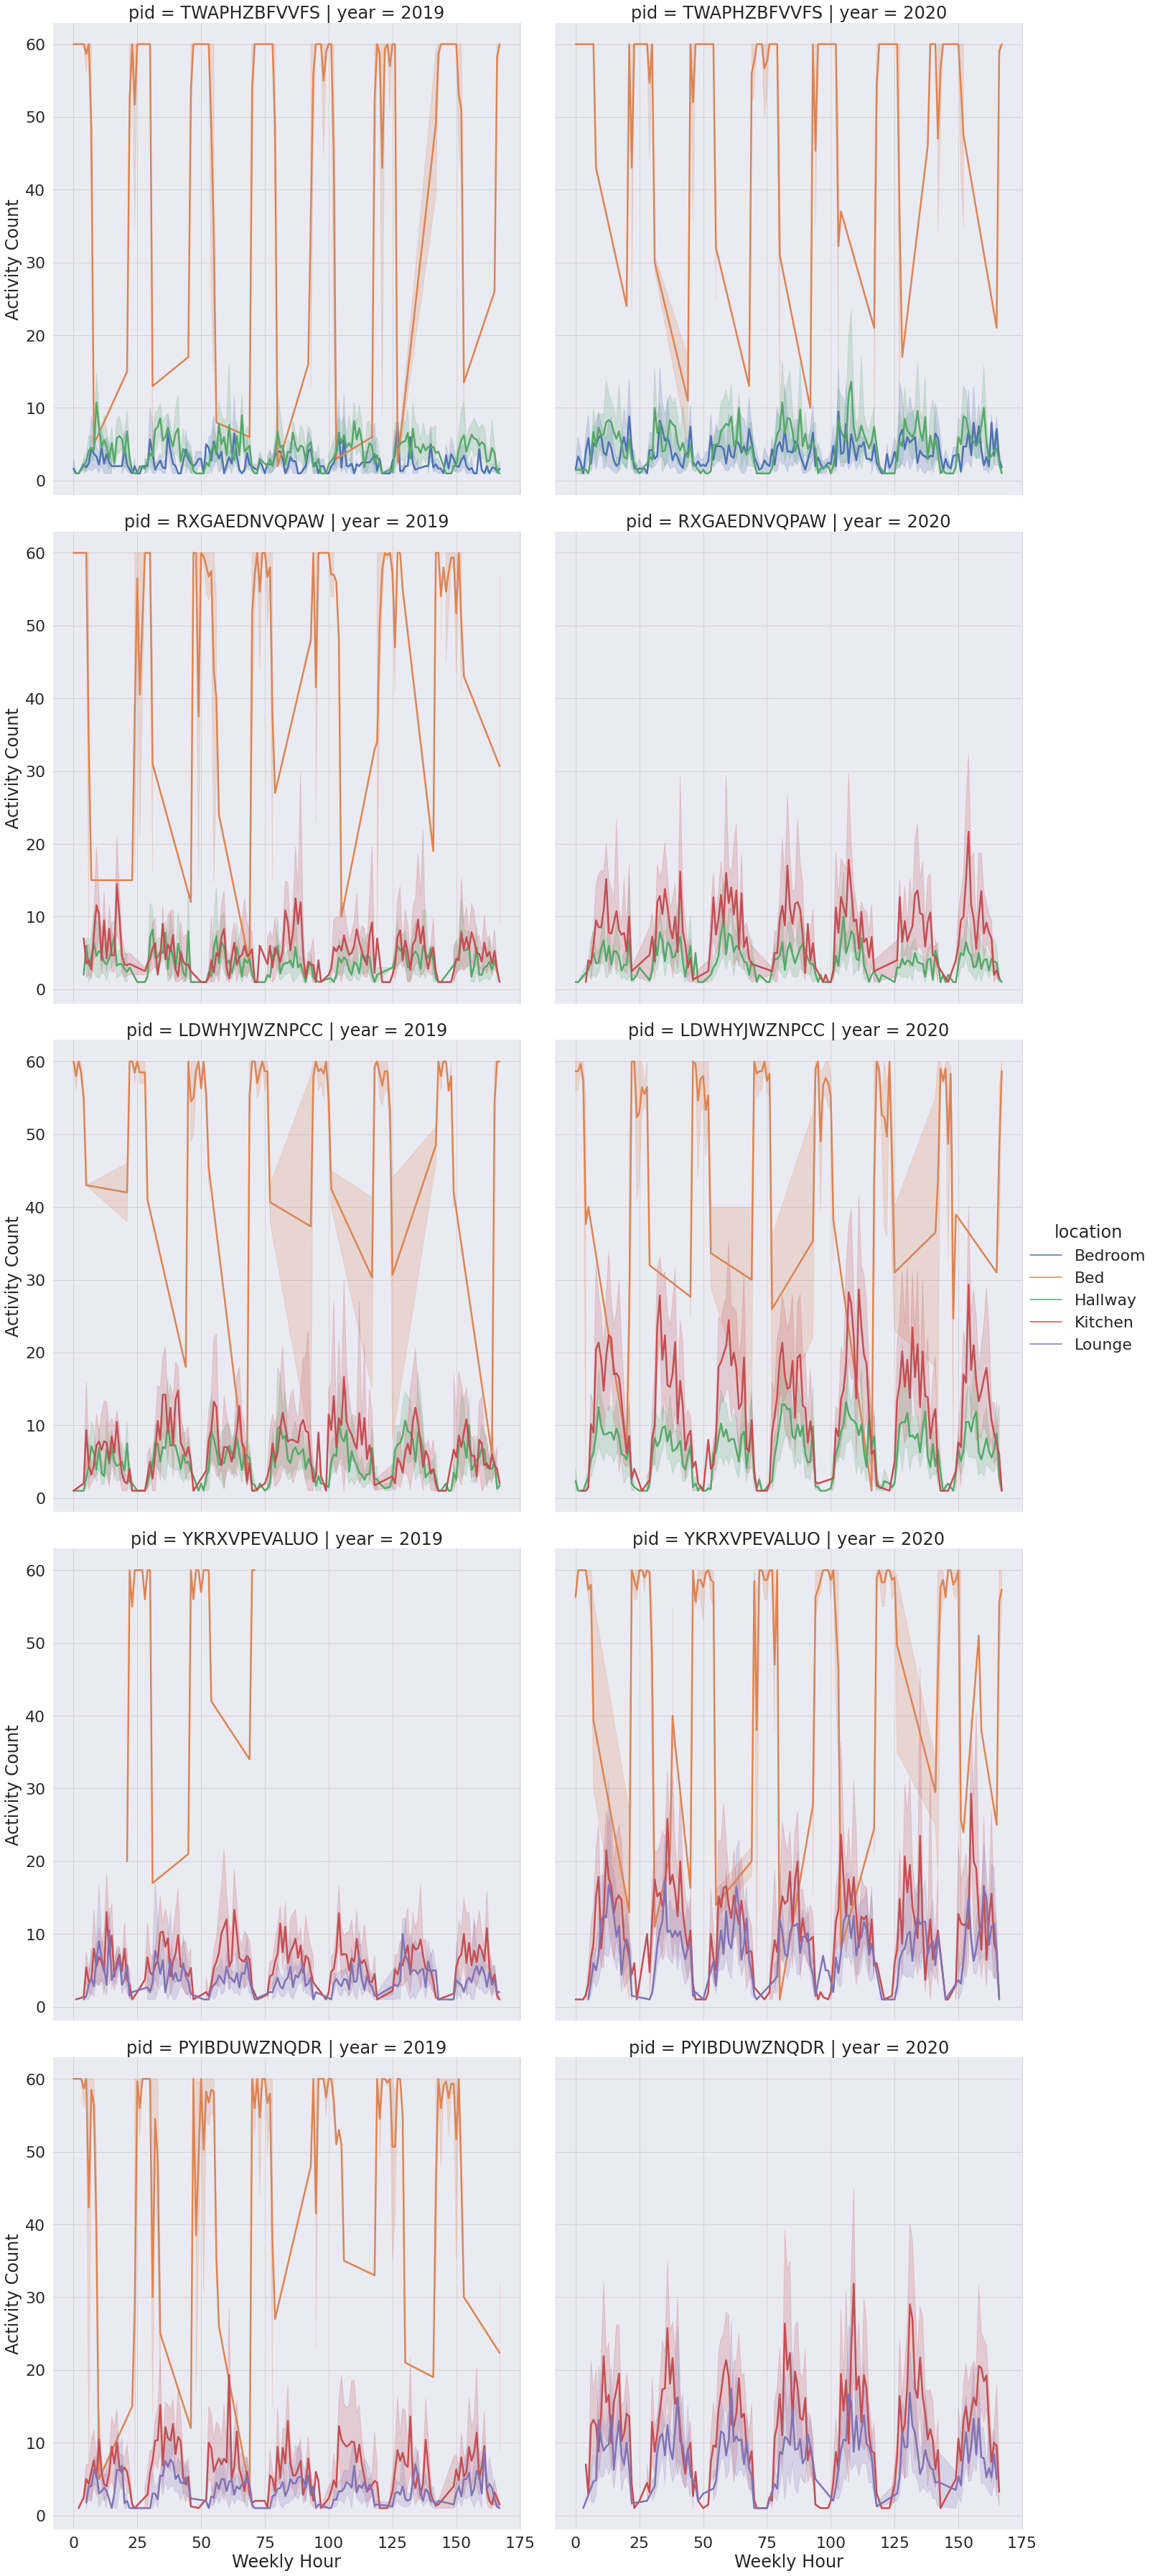

In [112]:
df_weekly = df[
    ['pid', 'year', 'week', 'weekday', 'hour', 'location', 'activity']
]
df_weekly['hour'] = df_weekly[['weekday', 'hour']].apply(
    lambda x: (x['weekday']-1) * 24 + x['hour'], axis=1
)
df_weekly = df_weekly[['pid', 'year', 'week', 'hour', 'location', 'activity']]
df_weekly = df_weekly.groupby(
    ['pid', 'year', 'week', 'hour', 'location']
).sum().reset_index().sort_values('hour')

df_temp = df_weekly.groupby(['pid', 'location'])['activity'].sum()
df_temp = df_temp.groupby(level='pid').nlargest(NLARGEST).reset_index(level=0, drop=True).reset_index()[['pid', 'location']]

keys = list(df_temp.columns.values)
i1 = df_weekly.set_index(keys).index
i2 = df_temp.set_index(keys).index
df_weekly = df_weekly[i1.isin(i2)]

g = seaborn.relplot(
    x='hour', y='activity', kind='line', linewidth=2.5, col='year',
    hue='location', data=df_weekly, height=10, aspect=1, row='pid'
)
# g.fig.autofmt_xdate()
g.set_axis_labels("Weekly Hour", "Activity Count")

In [ ]:
df_weekly = df[
    ['pid', 'year', 'week', 'weekday', 'hour', 'location', 'activity']
]
df_weekly['hour'] = df_weekly[['weekday', 'hour']].apply(
    lambda x: (x['weekday']-1) * 24 + x['hour'], axis=1
)
df_weekly = df_weekly[['pid', 'year', 'week', 'hour', 'location', 'activity']]
df_weekly = df_weekly.groupby(
    ['pid', 'year', 'hour', 'location']
).sum().reset_index().sort_values('hour')

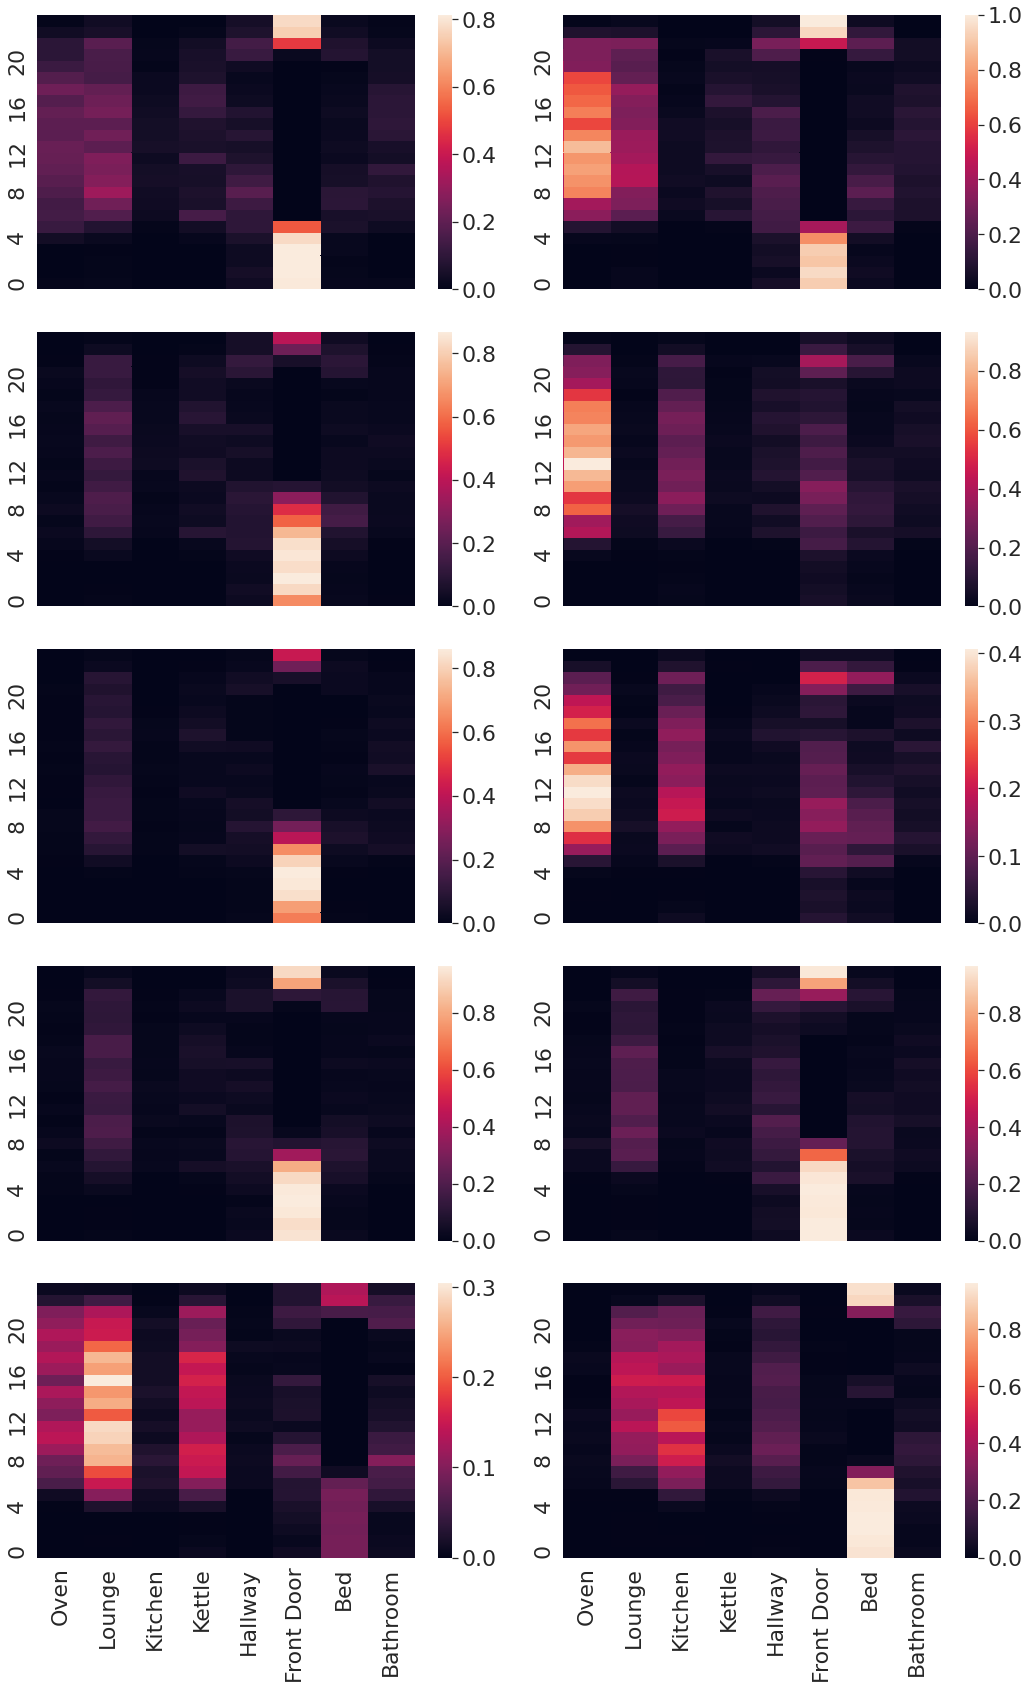

In [111]:
df_daily = df[['pid', 'year', 'hour', 'enum_loc', 'activity', 'location']]

df_daily = df_daily.groupby(
    ['pid', 'year', 'hour', 'enum_loc', 'location']
).sum().reset_index().sort_values('hour')
max_act = df_daily.activity.max()
df_daily['activity'] = df_daily.activity.apply(lambda x: x / max_act)

fig, axes = plt.subplots(5, 2, figsize=(15, 24), sharex=True)
for x_id, pid in enumerate(pids):
    for y_id, year in enumerate(years):
        seaborn.heatmap(
            df_daily[(df_daily.pid==pid) & (df_daily.year==year)].pivot('hour', 'location', 'activity').fillna(0),
            ax=axes[x_id, y_id], yticklabels=4,
        )
        axes[x_id, y_id].invert_xaxis()
        axes[x_id, y_id].invert_yaxis()
        axes[x_id, y_id].set_ylabel('')
        axes[x_id, y_id].set_xlabel('')
        # axes[x_id, y_id].set_xticklabels(axes[x_id, y_id].get_xticklabels(), rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
ENUM_LOC_PM = dict(
    zip(range(1, 12), [2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31])
)

def processed_metrics(df):
    start = df.index.to_series().min() + pd.Timedelta('10m')    
    df['deltatime'] = df.index.to_series().apply(
        lambda x: (x - start)
    ).astype('timedelta64[s]').astype('Int64')
    
    temp = df[
        (df['deltatime'] < 600) & (df['deltatime'] >= 0)
    ][['deltatime', 'location']].values
    duration = 0.0
    location = 1.0
    if len(temp):
        location = reduce(lambda x, y: x * y, list(set(temp[:, 1])), 1.0)
        duration = (-1 * temp[0][0]) if df[
            (df.index<start)
        ]['deltatime'].values[-1] < (600 - temp[0][0]) else 0
        temp = df[(df['deltatime'] >= 600)]['deltatime'].values
        if len(temp):
            duration += temp[0] if temp[0] < 1200 else 600.0
        else:
            duration += 600 
    
    return pd.DataFrame({
        'datetime': [df.index.min()],
        'nthweek': [(
            df.index.to_series().max() - df.index.to_series().min()
        ).total_seconds() / float(3600 * 24 * 7)],
        'duration': [np.min([duration / 600.0, 1.0])],
        'location': [location] 
    })

df_pid = df[
    (df['pid']=='LDWHYJWZNPCC') &
    (df['year']==2019)
][['datetime', 'location']].set_index('datetime').sort_index()

columns = ['datetime', 'nthweek', 'location', 'duration']
processed = pd.DataFrame({col: list() for col in columns})
start = df_pid.index.min()

prev_loc = 0
prev_time = df_pid.index.to_series().min()
while start < df_pid.index.max():
    mid_end = start + pd.Timedelta('30m')
    batch = df_pid[(df_pid.index >= start) & (df_pid.index < mid_end)]
    if len(batch):
        processed = pd.concat([processed, processed_metrics(batch)]) 
    start = start + pd.Timedelta('10m')

In [ ]:
processed.describe()